# PageRank as an optimization problem

The goal of this notebook is to implement Stochastic Gradient Descent (SGD) and compare it to Gradient Descent (GD) for solving the PageRank optimization problem
$$
\min_{x \in \mathbb{R}^n} f(x) := \frac{1}{2}\Vert Mx - x\Vert^2 + \frac{\lambda}{2} \left(\sum_{i=1}^n x[i] - 1\right)^2 ,
$$
where $M = (1 - \alpha)A + \alpha/n$, $\alpha \in ]0,1]$ ($0.15$ in our implementation), and $A$ is the link matrix of a web. The theoretical properties of GD and SGD for quadratic problems were studied in the course and TD 3.

In [1]:
#%reset -f
import os
import sys
import curses
import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as scisparse
import pkgutil
from time import time
#from importlib import reload
#from matplotlib import interactive
#interactive(True)
%matplotlib inline

# Utility functions

In [2]:
def mMatrix(A,alpha = 0.15):
    ''' Creates the regularized version of A with alpha=0.15 '''
    n = A.shape[0]
    M = (1-alpha)*A+alpha/n
    return M

def scorePageRank(A):
    ''' Computes the score vector using a full eigenvalue decomposition '''
    n = A.shape[0]
    M = mMatrix(A)
    v, w = np.linalg.eig(M)
    i = np.where(np.abs(v-1) < 1e-5)
    score = w[:, i].reshape((n, 1))
    score /= score.sum()
    return score.real

def dotProd(x, y):
    ''' Computes the dot product between x and y '''
    return np.ndarray.item(np.inner(x.reshape(-1), y.reshape(-1)))

def MakeCol(y): return y.reshape(-1,1)

def computeEigHF(A, lam):
    ''' Computes the eigenvalue decomposition of the Hessian to get the convergence rate of GD with step-size gamma.
    Parameters:
    -----------
        A (np.matrix): the matrix of links
        lam (float): regularization parameter
    Returns:
    --------
        v (float): the eignevalues of HF
    '''
    n = A.shape[0]
    M = mMatrix(A)
    In = np.eye(n)
    e = np.matlib.ones((n, 1))
    HF = (In-M).transpose()*(In-M) + lam*e*e.transpose()
    v, w= np.linalg.eig(HF)
    return v

# Miniwebs

In [3]:
def createMiniweb1():
    ''' Creates a 4x4 miniweb matrix '''
    A = np.matrix([[0, 1/3., 1/3., 1/3.],
                   [0, 0, 1/2., 1/2.],
                   [1, 0, 0, 0],
                   [1/2., 0, 1/2., 0]]).transpose()
    return A


def createMiniweb2():
    ''' Creates a 5x5 miniweb matrix '''
    A = np.matrix([[0, 1, 0, 0, 0],
                   [1, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0],
                   [0, 0, 1, 0, 0],
                   [0., 0, 1/2., 1/2., 0]]).transpose()
    return A


def createRandomWeb(n=15, density=0.15, sparse=True):
    ''' Creates a random web link matrix
    Parameters:
    -----------
        n (int, optional): size of the matrix
        density (float, optional) : density rate, should lie in [0,1]
        sparse (boolean, optional): True (sparse) False (full)
    Returns:
    --------
        A (np.matrix): the randomly generated link matrix
    Notes:
    ------
        The routine starts by choosing random connections, then add other
        random connections if some pages are not connected to any other, and
        then normalizes to compute the column-stochastic link matrix.
    '''
    A = np.matlib.zeros((n*n, 1))
    indices = np.random.choice(range(n*n), int(density*n*n), replace=False)
    A[indices] = 1
    A = A.reshape((n, n))
    nLinks = np.sum(A, 0)
    nonConnectedCols = np.arange(n)[np.asarray(nLinks).reshape(-1) == 0]
    nLinks = np.asarray(np.matlib.repmat(nLinks, n, 1))
    indices = np.random.choice(range(n), len(nonConnectedCols), replace=True)
    A[A != 0] = 1 / nLinks[A != 0]
    A[indices, nonConnectedCols] = 1
    if sparse is True:
        return scisparse.csr_matrix(A)
    else:
        return A 

# Gradient descent
Apply GD
$$ 
x_{k+1} = x_k - \gamma \nabla f(x_k)
$$
to solve the PageRank optimization problem. The gradient $\nabla f(x)$ must be computed efficiently as
$$
\nabla f(x) = x-z - (1-\alpha)A^\top(x-z) + \lambda(s-1)
$$
where $s=\sum_{i=1}^n x[i]$ and $z=(1-\alpha)Ax + \alpha s/n$.

In [4]:
## Insert your code here.
def grad_f(x, A, alpha=0.15, lam=0.0):
    n = x.shape[0]
    s = np.sum(x)
    z = (1 - alpha) * (A @ x) + alpha * s / n * np.ones((n, 1))
    r = x - z
    g = r - (1 - alpha) * (A.T @ r) + lam * (s - 1) * np.ones((n, 1))
    return g

# Stochastic Gradient Descent
The PageRank optimization objective can be equivalently written as
$$
f(x) = \frac{1}{2(n+1)}\Vert \mathcal{A} x - b\Vert^2 .
$$
where $\mathcal{A}=\begin{pmatrix} I - M \\ \sqrt{\lambda} E \end{pmatrix}$ and $b=(0,\cdots,0,\sqrt{\lambda})^\top$, $E=(1,\ldots,1)$. Computing $\nabla f(x)$ is prohibitive for large $k$ (cost/iter is $O(n^2)$ for dense and $O(density*n^2)$ for sparse graph). This finite sum structure (empirical risk) is amenable to SGD
$$ 
x_{k+1} = x_k - \gamma \nabla f_{i_k}(x_k)
$$
where $i_k$ is drawn uniformly at random in $\{1,\ldots,n+1\}$, and
$$
\nabla f_i(x) = 
\begin{cases}
\left((1-\alpha)a_i +  \frac{\alpha}{n} - e_i\right) \left((1-\alpha)\langle a_i,x \rangle + \frac{\alpha}{n} \sum_{j=1}^n x[j] - x[i]\right) & i=1,\ldots,n , \\
\lambda \left(\sum_{j=1}^n x[j] - 1\right) & i=n+1 ,
\end{cases}
$$
with $a_i = A[i,:]^\top$. Computing $\nabla f_i(x)$ costs $O(n)$ per iteration. See also the comparison of running times is the last section of this notebook.

In [5]:
## Insert your code here.
def grad_fi(x, A, i, alpha=0.15, lam=0.0):
    n = x.shape[0]
    e = np.ones((n,1))
    s = np.sum(x)
    if i < n:
        ai = A[:, i].reshape(-1,1)
        xi = x[i,0]
        ri = (1-alpha) * float(ai.T @ x) + alpha * s / n - xi
        gi = (1-alpha) * ai + alpha / n * e
        gi[i] -= 1
        return ri * gi
    else:
        return lam * (s - 1) * e


# Test and compare SGD and GD for different miniwebs
* Monitor the residual error decay. 
* Test different step-sizes, and compare with the theory (in particular plot in log domain to illustrate the linear rate). 

In [6]:
## Insert your code here.
A = createMiniweb1()
n = A.shape[0]

x_star = scorePageRank(A)
x0 = np.zeros((n,1))
lam = 1/n

eigHF = computeEigHF(A, lam)
beta = np.max(eigHF.real)

gammas = [0.5/beta, 1.0/beta, 1.99/beta]

In [7]:
def run_GD(A, x0, gamma, n_iter, alpha=0.15, lam=0.0):
    x = x0.copy()
    res = []
    for k in range(n_iter):
        x = x - gamma * grad_f(x, A, alpha, lam)
        res.append(np.linalg.norm(x - x_star))
    return np.array(res)

In [8]:
def run_SGD(A, x0, gamma, n_iter, alpha=0.15, lam=0.0):
    x = x0.copy()
    res = []
    n = x.shape[0]
    for k in range(n_iter):
        i = np.random.randint(0, n+1)
        x = x - gamma * grad_fi(x, A, i, alpha, lam)
        res.append(np.linalg.norm(x - x_star))
    return np.array(res)

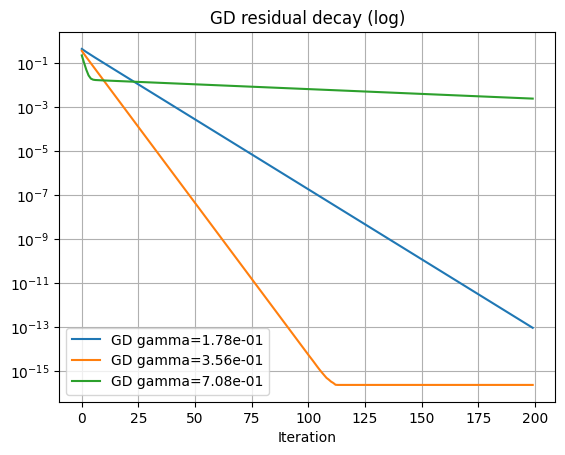

In [9]:
for gamma in gammas:
    res_gd = run_GD(A, x0, gamma, 200, alpha=0.15, lam=lam)
    plt.semilogy(res_gd, label=f"GD gamma={gamma:.2e}")

plt.xlabel("Iteration")
plt.title("GD residual decay (log)")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_61180/1297307046.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ri = (1-alpha) * float(ai.T @ x) + alpha * s / n - xi


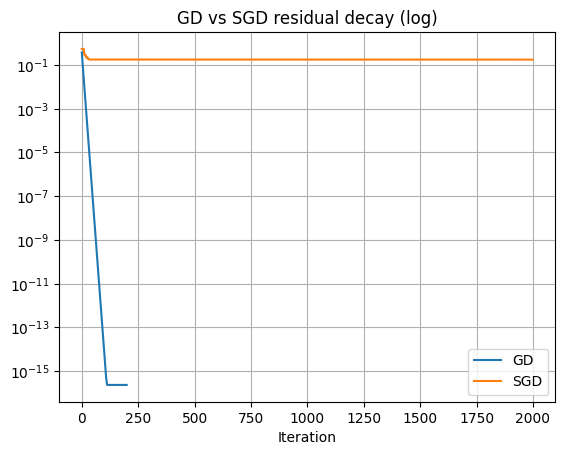

In [10]:
gamma = 1.0 / beta

res_gd = run_GD(A, x0, gamma, 200, alpha=0.15, lam=lam)
res_sgd = run_SGD(A, x0, gamma, 2000, alpha=0.15, lam=lam)

plt.figure()
plt.semilogy(res_gd, label="GD")
plt.semilogy(res_sgd, label="SGD")
plt.xlabel("Iteration")
plt.title("GD vs SGD residual decay (log)")
plt.legend()
plt.grid(True)
plt.show()


# Compare running times
Compare running times for increasingly large graphs with a fixed sparsity rate and for different implementations of PageRank (GD and SGD with sparse vs dense $A$).

In [11]:
## Insert your code here.
def time_GD(A, x0, gamma, n_iter=50, alpha=0.15, lam=0.0):
    x = x0.copy()
    t0 = time()
    for _ in range(n_iter):
        x = x - gamma * grad_f(x, A, alpha, lam)
    return (time() - t0) / n_iter

In [12]:
def time_SGD(A, x0, gamma, n_iter=200, alpha=0.15, lam=0.0):
    x = x0.copy()
    n = x.shape[0]
    t0 = time()
    for _ in range(n_iter):
        i = np.random.randint(0, n+1)
        x = x - gamma * grad_fi(x, A, i, alpha, lam)
    return (time() - t0) / n_iter

/tmp/ipykernel_61180/1297307046.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ri = (1-alpha) * float(ai.T @ x) + alpha * s / n - xi


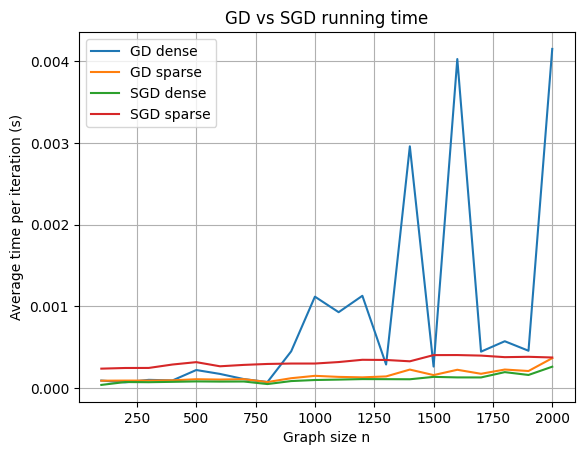

In [13]:
sizes = range(100, 2100, 100)
density = 0.01

times_gd_dense  = []
times_gd_sparse = []
times_sgd_dense = []
times_sgd_sparse = []

for n in sizes:
    A_dense  = createRandomWeb(n, density=density, sparse=False)
    A_sparse = createRandomWeb(n, density=density, sparse=True)

    x0 = np.zeros((n,1))
    lam = 1/n

    beta = np.max(computeEigHF(A_dense, lam).real)
    gamma = 1.0 / beta

    times_gd_dense.append(
        time_GD(A_dense, x0, gamma, lam=lam)
    )

    times_gd_sparse.append(
        time_GD(A_sparse, x0, gamma, lam=lam)
    )

    times_sgd_dense.append(
        time_SGD(A_dense, x0, gamma, lam=lam)
    )

    times_sgd_sparse.append(
        time_SGD(A_sparse, x0, gamma, lam=lam)
    )

plt.figure()
plt.plot(sizes, times_gd_dense,  label="GD dense")
plt.plot(sizes, times_gd_sparse, label="GD sparse")
plt.plot(sizes, times_sgd_dense, label="SGD dense")
plt.plot(sizes, times_sgd_sparse,label="SGD sparse")
plt.xlabel("Graph size n")
plt.ylabel("Average time per iteration (s)")
plt.title("GD vs SGD running time")
plt.legend()
plt.grid(True)
plt.show()
